In [1]:
# Example - https://github.com/cornelliusyudhawijaya/Churn_Causality_Analysis/blob/main/Causal%20Analysis%20Do%20Why.ipynb
    
import numpy as np
import pandas as pd

from dowhy import CausalModel
import dowhy.datasets 

# Avoid printing dataconversion warnings from sklearn and numpy
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings('ignore')

# Prepare Data

In [2]:
data = pd.read_csv('../../../data/GermanData.csv')

## Drop categorical features
data = data.drop(['1','2','4','5','8','10','11','12','14','15','16','17','18','19','20'],axis=1)


## Drop NULL values
data = data.dropna()

## for dowhy
## Change symbolics to numerics
data['sex'] = np.where(data['sex'] == 'A91', 1, data['sex'])
data['sex'] = np.where(data['sex'] == 'A92', 0, data['sex'])
data['sex'] = np.where(data['sex'] == 'A93', 1, data['sex'])
data['sex'] = np.where(data['sex'] == 'A94', 1, data['sex'])
data['sex'] = np.where(data['sex'] == 'A95', 0, data['sex'])

# mean = data.loc[:,"age"].mean()
# data['age'] = np.where(data['age'] >= mean, 1, 0)
data['age'] = np.where(data['age'] >= 25, 1, 0)
data['credit_history'] = np.where(data['credit_history'] == 'A30', 1, data['credit_history'])
data['credit_history'] = np.where(data['credit_history'] == 'A31', 1, data['credit_history'])
data['credit_history'] = np.where(data['credit_history'] == 'A32', 1, data['credit_history'])
data['credit_history'] = np.where(data['credit_history'] == 'A33', 2, data['credit_history'])
data['credit_history'] = np.where(data['credit_history'] == 'A34', 3, data['credit_history'])

data['savings'] = np.where(data['savings'] == 'A61', 1, data['savings'])
data['savings'] = np.where(data['savings'] == 'A62', 1, data['savings'])
data['savings'] = np.where(data['savings'] == 'A63', 2, data['savings'])
data['savings'] = np.where(data['savings'] == 'A64', 2, data['savings'])
data['savings'] = np.where(data['savings'] == 'A65', 3, data['savings'])

data['employment'] = np.where(data['employment'] == 'A72', 1, data['employment'])
data['employment'] = np.where(data['employment'] == 'A73', 1, data['employment'])
data['employment'] = np.where(data['employment'] == 'A74', 2, data['employment'])
data['employment'] = np.where(data['employment'] == 'A75', 2, data['employment'])
data['employment'] = np.where(data['employment'] == 'A71', 3, data['employment'])

data['Probability'] = np.where(data['Probability'] == 2, 0, 1)

non_numeric_columns = list(data.select_dtypes(exclude=[np.number]).columns)

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

for col in non_numeric_columns:
    data[col] = le.fit_transform(data[col])

print(non_numeric_columns)

from sklearn.preprocessing import MinMaxScaler,StandardScaler

scaler = MinMaxScaler()
# dataset_orig = pd.DataFrame(scaler.fit_transform(data),columns = data.columns)

protected_attribute = "sex"

dataset_orig = data.copy()
dataset_orig

['credit_history', 'savings', 'employment', 'sex']


,credit_history,savings,employment,sex,age,Probability
0,2,2,1,1,1,1
1,0,0,0,0,0,0
2,2,0,1,1,1,1
3,0,0,1,1,1,1
4,1,0,0,1,1,0
...,...,...,...,...,...,...
995,0,0,1,0,1,1
996,0,0,0,1,1,1
997,0,0,1,1,1,1
998,0,0,0,1,0,0


In [3]:
# This dataset size is very small. So repeating it to make it bigger

dataset_orig = pd.concat([dataset_orig]*5, ignore_index=True)

# Transform data using LFR

In [6]:
from aif360.algorithms.preprocessing.lfr import LFR
from aif360.datasets import BinaryLabelDataset
from IPython.display import Markdown, display
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split

protected_attribute = "sex"
dataset_orig_train, dataset_orig_test = train_test_split(dataset_orig, test_size=0.2,random_state=0)
privileged_groups = [{protected_attribute: 1}]
unprivileged_groups = [{protected_attribute: 0}]

TR = LFR(unprivileged_groups=unprivileged_groups,
         privileged_groups=privileged_groups,
#          k=10, Ax=1, Ay=1.0, Az=10.0,
         verbose=1)

dataset_orig_train = BinaryLabelDataset(df=dataset_orig_train, label_names=['Probability'], protected_attribute_names=[protected_attribute])

TR.fit(dataset_orig_train, maxiter=500, maxfun=500)

dataset_transf = TR.transform(dataset_orig_train)
dataset_orig_train, yy = dataset_transf.convert_to_dataframe()

from sklearn.linear_model import LogisticRegression
from Measure import measure_final_score,calculate_recall,calculate_far,calculate_precision,calculate_accuracy

X_train, y_train =  dataset_orig_train.loc[:, dataset_orig_train.columns != 'Probability'], dataset_orig_train['Probability']
X_test, y_test = dataset_orig_test.loc[:, dataset_orig_test.columns != 'Probability'], dataset_orig_test['Probability']
        
clf = LogisticRegression(C=1.0, penalty='l2', solver='liblinear', max_iter=100) # LSR
clf.fit(X_train,y_train)

print("aod :"+protected_attribute,measure_final_score(dataset_orig_test, clf, X_train, y_train, X_test, y_test, protected_attribute, 'aod'))
print("eod :"+protected_attribute,measure_final_score(dataset_orig_test, clf, X_train, y_train, X_test, y_test, protected_attribute, 'eod'))
print("SPD:",measure_final_score(dataset_orig_test, clf, X_train, y_train, X_test, y_test, protected_attribute, 'SPD'))
print("DI:",measure_final_score(dataset_orig_test, clf, X_train, y_train, X_test, y_test, protected_attribute, 'DI'))

step: 0, loss: 2.0825850491196225, L_x: 0.8430360492633664,  L_y: 0.666575832316507,  L_z: 0.028151577126209637
step: 250, loss: 0.7186430616070987, L_x: 0.8498628588400394,  L_y: 0.6539975283309216,  L_z: 0.0011229380937555322
step: 500, loss: 0.6997083200675452, L_x: 0.8496947796651106,  L_y: 0.6533977506387091,  L_z: 0.0007562724326437009
aod :sex 0.02
eod :sex -0.07
SPD: 0.08
DI: -0.11


# Graph

In [20]:
causal_graph = """
digraph {
credit_history;
savings;
employment;
age;
sex;
Probability;
U[label="Unobserved Confounders"];
sex -> Probability;
sex -> employment; employment -> Probability;
credit_history -> Probability;
savings -> Probability;
credit_history -> savings;
age -> savings;
U->sex;U->Probability;
}
"""

## dowhy works for binary inputs only


dataset_orig_train['Probability'] = np.where(dataset_orig_train['Probability'] == 0, False, True)
dataset_orig_train[protected_attribute] = np.where(dataset_orig_train[protected_attribute] == 1, True, False)

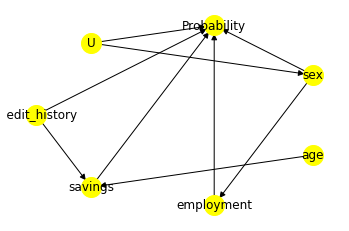

In [21]:
# With graph
model=CausalModel(
        data = dataset_orig_train,
        treatment=protected_attribute,
        outcome="Probability",
        graph=causal_graph.replace("\n", " ")
        )
model.view_model()


In [22]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

causal_estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_stratification")
print(causal_estimate)
print("Causal Estimate is " + str(causal_estimate.value))

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                                        
──────(Expectation(Probability|savings,age,credit_history))
d[sex]                                                     
Estimand assumption 1, Unconfoundedness: If U→{sex} and U→Probability then P(Probability|sex,savings,age,credit_history,U) = P(Probability|sex,savings,age,credit_history)

### Estimand : 2
Estimand name: iv
No such variable found!

### Estimand : 3
Estimand name: frontdoor
No such variable found!

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                                        
──────(Expectation(Probability|savings,age,credit_history))
d[sex]                                                     
Estimand assumption 1, Unconfoundedness: If U→{sex} and U→Probability then P(Probability|sex,savings,

In [204]:
causal_estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_stratification")
print(causal_estimate)
print("Causal Estimate is " + str(causal_estimate.value))

ValueError: Method requires strata with number of data points per treatment > clipping_threshold (=10). No such strata exists. Consider decreasing 'num_strata' or 'clipping_threshold' parameters.

In [11]:
refutel = model.refute_estimate(identified_estimand,causal_estimate, "random_common_cause")
print(refutel)
print("++"*20)
refutel = model.refute_estimate(identified_estimand,causal_estimate,method_name="placebo_treatment_refuter",placebo_type="permute")
print(refutel)
print("++"*20)
refutel = model.refute_estimate(identified_estimand,causal_estimate, "data_subset_refuter")
print(refutel)

Refute: Add a Random Common Cause
Estimated effect:0.0
New effect:0.0

++++++++++++++++++++++++++++++++++++++++
Refute: Use a Placebo Treatment
Estimated effect:0.0
New effect:0.0
p value:1.0

++++++++++++++++++++++++++++++++++++++++
Refute: Use a subset of data
Estimated effect:0.0
New effect:0.0
p value:1.0



In [ ]:
# Causal effect on the control group (ATC)
causal_estimate_att = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_stratification",
        target_units = "atc")
print(causal_estimate_att)
print("Causal Estimate is " + str(causal_estimate_att.value))

# Add Random Common Cause

In [ ]:
refutel = model.refute_estimate(identified_estimand,causal_estimate, "random_common_cause")
print(refutel)

# Replace Treatment with Placebo

In [ ]:
refutel = model.refute_estimate(identified_estimand,causal_estimate,method_name="placebo_treatment_refuter",placebo_type="permute")
print(refutel)

# Remove Random Subset of Data

In [ ]:
refutel = model.refute_estimate(identified_estimand,causal_estimate, "data_subset_refuter")
print(refutel)